# 8.3 The Pinhole model

In notebook 8.1, it was said that **image formation** is the process of projecting the elements appearing in a **3D scene** (objects, surfaces, landscapes, etc.) on the **2D image plane**. Such 3D scene could be:

- the real world captured by a camera, 
- a videogame engine transforming the 3D virtual enviroment to images simulating the player point of view,
- and so on.$\\[5pt]$

<img src="./images/intro.jpg" width="500"/>$\\[5pt]$

Now that we know how **homogenous coordinates**, **2D homographies** and **translation + rotation transformations in 3D spaces** work, it's the moment to learn how an image formation model works.  

In this notebook we will study:

- the **Pinhole model**
- the **camera model**

## Problem context - RGB-D images

RGB-depth (RGB-D) images are 4-bands images, where the last band contains  the information about the distance of the pixels to the camera.$\\[10pt]$

<img src="./images/kinect.png" width="600"/>$\\[5pt]$

These images have been used by [Microsoft's Kinect](https://en.wikipedia.org/wiki/Kinect) for segmentate the people using it from the background of the image.  

RGB-D images actually form a 3D map and they are a **good example for learning how image formation models work**, this is because we can turn images to 3D maps (using the depth) and the other way around (3D scene to 2D image plane).

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
images_path = './images/'
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
%matplotlib notebook

import sys
sys.path.append("..")
from utils.plot3DScene import plot3DScene

Until now, you used homogenous coordinates for homography. An interesting property of homogenous coordinates is that the **homogeneus coordinates of a point in the plane ($\mathbb{R}^2$) transform to a line passing through the origin in a reference frame parallel to tlhe image plane**:$\\[10pt]$

<img src="./images/homogenous.png" width="600"/>$\\[5pt]$
 
The projective plane, called $\mathbb{P}^2$, is the set of 3-tuples of real numbers, such that $\begin{bmatrix}x_1 \\ x_2 \\ 1\end{bmatrix} \equiv k \begin{bmatrix}x_1 \\ x_2 \\ 1\end{bmatrix}, \ k \ne 0$.

- A point in $\mathbb{P}^2$ (3-tuple) is represented in ($\mathbb{R}^3$) as a line passing through the origin
- $k$ is the component (depth): indicates a specific point along the line
 
 
### The pinhole model

In the Pinhole model we want to project the 3D world (set of $\begin{bmatrix}X & Y & Z\end{bmatrix}^T$ points) in a plane called image plane. We have a camera placed at $C = \begin{bmatrix}0 & 0 & 0\end{bmatrix}^T$ in the world (center of the coordinate system). This camera have a fixed property $f$ called focal length, which is where the camera sensor is placed in the interior of the camera. The camera sensor is the plane where the images of the real world are projected:

<img src="./images/pinhole.png" width="400"/>$\\[5pt]$

To operate with this image formation model, we need to know how to project a world point to the image plane and the other way around. For this, we are going to use the property  of homogenous coordinated mentioned above.

**From 2D to 3D**

Given a point $\begin{bmatrix}x & y\end{bmatrix}^T \in \mathbb{R}^2$ in the image, its **projection line** in the camera plane is very simple to compute:

Projection line through $\begin{bmatrix}x & y & f\end{bmatrix}^T \in \mathbb{R}^3$ (we add third component $f$ because image plane is placed at $f$ in $z$-axis):$\\[5pt]$

$$k \begin{bmatrix}x \\ y \\ f \end{bmatrix} \in \mathbb{P}^2$$

*Remember that $k$ indicates a specific 3D point along the projection line.*

If we set $k=2$ we have the point:$\\[5pt]$

$$ \begin{bmatrix}2x \\ 2y \\ 2f \end{bmatrix} \in \mathbb{R}^3 \\[5pt]$$

Note that $k$ does not correspond directly to the third component of the 3D point. We can fix this dividing by the focal length:$\\[5pt]$

$$k' \begin{bmatrix} x \ / \ f  \\ y \ / \ f \\ 1 \end{bmatrix} \in \mathbb{P}^2 \\[5pt]$$ 

Now $k'$ indicates the depth of the 3D point, if we know that the depth of a pixel is 5, we only have to set $k'=5$.$\\[10pt]$

**From 3D to 2D**$\\[5pt]$

Given any 3D point $M = \begin{bmatrix}X & Y & Z \end{bmatrix}^T \in \mathbb{R}^3$, we know that it have a projected point in the image plane $m = \begin{bmatrix}x & y \end{bmatrix}^T \in \mathbb{R}^2$.  

As seen before, the 3D point in the projection line of $m$ with depth $Z$ is:$\\[5pt]$

$$Z \begin{bmatrix} x \ / \ f  \\ y \ / \ f \\ 1 \end{bmatrix} = \begin{bmatrix} Zx \ / \ f  \\ Zy \ / \ f \\ Z \end{bmatrix} \in \mathbb{R}^3 \\[5pt]$$ 

In that way:$\\[5pt]$

$$M = \begin{bmatrix}X \\ Y \\ Z \end{bmatrix} =  \begin{bmatrix} Zx \ / \ f  \\ Zy \ / \ f \\ Z \end{bmatrix} \longrightarrow \begin{eqnarray} X = \frac{Zx}{f}\ \rightarrow \ x = \frac{fX}{Z} \\[3pt] Y = \frac{Zy}{f} \ \rightarrow \ y = \frac{fY}{Z} \end{eqnarray} \\[5pt]$$ 

Finally, we can conclude that:$\\[10pt]$
<img src="./images/3dto2d.png" width="400"/>$\\[5pt]$

*Note that this transformation is not linear, but* **becomes linear if we use homogenous coordinates**:$\\[5pt]$

$$\begin{bmatrix} f & 0 & 0 & 0 \\ 0 & f & 0 & 0 \\ 0 & 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} = \begin{bmatrix} fX \\ fY \\ Z\end{bmatrix} \xrightarrow{\text{homogenous to cartesian}} \begin{bmatrix} fX \ / \ Z \\ fY \ / \ Z \end{bmatrix} \\[5pt]$$

Usually, this transformation is decomposed as $Z \tilde{m} = K_f\underbrace{P_0\tilde{M}_C}_{Z\tilde{m}_1}:\\[5pt]$

$$Z \underbrace{\begin{bmatrix} x  \\ y \\ 1 \end{bmatrix}}_{\tilde{m}} = \underbrace{\begin{bmatrix} f & 0 & 0\\ 0 & f & 0  \\ 0 & 0 & 1\end{bmatrix}}_{K_f}\underbrace{\begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0  \\ 0 & 0 & 1 & 0\end{bmatrix}}_{P_0 = [I|0]}\begin{bmatrix} X  \\ Y \\ Z \\ 1 \end{bmatrix}$$

<img src="./images/3dto2d-2.png" width="700"/>$\\[5pt]$


**Your first task** is transforming the world points given in matrix `world` to coordinates in the image plane using a focal length of $2.5$. You should use to use **only** linear transformations.

In [9]:
# World coordinates
world = np.array([[12,21,30,41,67,54,33,24,46,58],[21,26,34,23,42,67,76,54,42,37],[10,7,2,13,4,7,5,15,8,7]])

# Focal length


# Convert world coordinates to homogenous


# Define transformation matrices


# Get homogenous sensor coordinates


# Transform to cartesian


[[ 3.     7.5   37.5    7.885 41.875 19.286 16.5    4.    14.375 20.714]
 [ 5.25   9.286 42.5    4.423 26.25  23.929 38.     9.    13.125 13.214]]


You can **test if results are correct**:

<font color='blue'>**Expected output:**  </font>

    [[ 3.     7.5    37.5  7.885  41.875  19.286  16.5  4.  14.375   20.714]
     [ 5.25   9.286  42.   4.423  26.25   23.929  38.   9.  13.125   13.214]]


### The camera model

Pinhole model is not useful at all, this is because 

- the camera frame point $m$ is known in the sensor, but they are needed in image pixels (not in meters).
- usually, the camera is not the center of the coordinate system. 

This is where we define the **camera model**, which include some linear transformations for solving this problem.$\\[10pt]$

<img src="images/cameramodel.png" width="600">$\\[5pt]$

**From world frame to camera frame**: R, t (3D $\rightarrow$ 3D)

In this transformation, we are going to **transform a 3D world frame** (where the center of the coordinate system is a fixed point in the world), **to the camera frame** (where the camera is the center of the coordinate system). 

As said before, the camera shouldn't be the world center. This is because the camera moves through the world, or even there is more than one camera.$\\[10pt]$

<img src="images/world_camera.png" width="500">$\\[5pt]$

In notebook 8.1, we learned how to apply a rotation + translation to a 3D set of points:$\\[5pt]$

$$M_C = RM_W + t \ \xrightarrow{\text{In homogenous}} \ \tilde{M}_C = D \tilde{M}_W$$

If we add this transformation to the Pinhole model, the new **Perspective Projection equation**:

$$\lambda \tilde{m} = K_f P_0 \tilde{M}_C = K_f P_0 D \tilde{M}_W$$

**From sensor image to computer image:** 2D $\rightarrow$ 2D

We obtain coordinates on the sensor (units in *meters*) when Pinhole model is applied, but this is not the final step. What we need is the **image matrix coordinates (units: *row, column*)**, which are the units we use in the computer.$\\[10pt]$

<img src="images/sensor_matrix.png" width="600">$\\[5pt]$

As you can see, both images are related by an **affine** transormation (2D homography, *notebook 8.2*). As we know, affine transformations allow **rotation + translation + scale** (different for each axis). In this case we don't need any rotation, but axes scale:

$$m' = Am + b = \begin{bmatrix}k_x & 0 \\ 0 & k_y\end{bmatrix}\underbrace{\begin{bmatrix} x \\ y \end{bmatrix}}_{\text{meter}} + \underbrace{\begin{bmatrix} x'_0 \\ y'_0 \end{bmatrix}}_{\text{pixels}} \xrightarrow{\text{In homogenous}} \begin{bmatrix} x' \\ y'\\ 1 \end{bmatrix} = \begin{bmatrix} k_x & 0 & x'_0  \\ 0 & k_y & y'_0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y\\ 1 \end{bmatrix} \qquad \bf{\tilde{m}' = K_s \tilde{m}}$$

Where $x'_0$ and $y'_0$ are the columns and rows from the center o pixel to the bottom left pixel of the image. Also, $s_y $ and $s_x$ are scale factors, both intrinsic to the camera.

Typically, the image matrix has the coordinate system at the left-top corner $\rightarrow$ another 2D homography (euclidean transformation) is required:$\\[10pt]$

<img src="images/sensor_matrix_2.png" width="900">$\\[5pt]$

$$\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} =  \begin{bmatrix} cos(\theta) & -sin(\theta) & t_x \\ sin(\theta) & cos(\theta) & t_y \\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix} \xrightarrow[\theta = 90º]{t = [M \ 0]^T} \begin{bmatrix} 0 & -1 & M \\ 1 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix}\underbrace{\begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix}}_{\text{pixels}} = \underbrace{\begin{bmatrix}M - y' \\ x' \\ 1 \end{bmatrix}}_{\text{pixels}}$$

Where $M = y'_0 + u_0$ is the number of rows of the image.

For reducing the computation time and save code, we can merge both transformations:$\\[10pt]$

<img src="images/sensor_transformations.png" width="900">$\\[5pt]$

$$\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = \underbrace{\begin{bmatrix} 0 & -1 & M \\ 1 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix}}_{H_1} \underbrace{\begin{bmatrix} k_x & 0 & x'_0 \\ 0 & k_y & y'_0 \\ 0 & 0 & 1 \end{bmatrix}}_{H_2}\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} = \begin{bmatrix} 0 & -k_y & M-y'_0 \\ k_x & 0 & x'_0 \\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} \xrightarrow[M = y'_0 + u_0]{x'_0 = v_0} \begin{bmatrix} 0 & -k_y & u_0 \\ k_x & 0 & v_0 \\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} = \begin{bmatrix} -k_yy + u_0 \\ k_xx + v_0 \\ 1 \end{bmatrix}$$

Remember that $k_x, k_y, x'_0$ and $y'_0$ are intrinsic values of the camera, this means that are always constant (for the same camera).

**What to do?** Transform the sensor coordinates (meters) obtained in previous exersise to image coordinates (pixels). For this, you will need the intrinsic parameters of the camera (we will learn to calcule them in next notebook). Anyway, for this example you can use:

$
k_x = 2, \
k_y = 3, \
x_0 = 300, \
y_0 = 200, \
M = 500, \
$

In [10]:
# Define intrinsic parameters


# Transformation matrix


# Transform sensor coordinates to image coordinates


# Transform to cartesian


[[284 272 172 286 221 228 186 273 260 260]
 [306 315 375 315 383 338 333 308 328 341]]


You can **test if results are correct**:

<font color='blue'>**Expected output:**  </font>

    [[284 272 172 286 221 228 186 273 260 260]
     [306 315 375 315 383 338 333 308 328 341]]



**Perspective matrix: General form**

Let's see how the final transformation would be **from 3D world frame to computer image** (with coordinate system at bottom left corner):

$$\lambda \begin{bmatrix} x' \\ y'\\ 1 \end{bmatrix} = \underbrace{\begin{bmatrix} k_x & 0 & x'_0  \\ 0 & k_y & y'_0 \\ 0 & 0 & 1 \end{bmatrix}}_{\text{from sensor to image}}\underbrace{\begin{bmatrix} f & 0 & 0  \\ 0 & f & 0 \\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix} 1 & 0 & 0 & 0  \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \end{bmatrix}}_{\text{from camera frame to sensor}}\underbrace{\begin{bmatrix} \bf{R} & \bf{t}  \\ \bf{0^T_3} & 1 \end{bmatrix}}_{\text{from world to camera frame}} \begin{bmatrix} X_W \\ Y_W\\ Z_W \\ 1 \end{bmatrix}$$

Again, we can merge some transformations:

$$\lambda \begin{bmatrix} x' \\ y'\\ 1 \end{bmatrix} = \begin{bmatrix} f k_x & 0 & x'_0  \\ 0 & f k_y & y'_0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} \bf{R} & \bf{t}\end{bmatrix} \begin{bmatrix} X_W \\ Y_W\\ Z_W \\ 1 \end{bmatrix} \qquad \bf{\lambda \tilde{m}' = K \left[ R\ t \right] \tilde{M}_W}$$

Where 
- $\bf{R}$ and $\bf{t}$ are extrinsic values (depend on the camera position)
- $f$, $\ k_x$, $\ k_y$, $\ x'_0$ and $y'_0$ are intrinsic (constant) values that depends on the camera that is being used.

The full camera model in action:$\\[10pt]$

<img src="images/camera_model.png" width="700">$\\[5pt]$

**For a visual explanation of this model, you can check** [this interactive application](http://ksimek.github.io/2012/08/22/extrinsic/).

### Exercise: RGB-D  image

We are going to apply the Pinhole camera model to draw a 3D map from a RGB-D image. For this, we need to transform a 2D point in the RGB image to a 3D point in the world frame.

**What to do?** First of all, let's show the RGB-D image, that is composed by `person_rgb.png` and `person_depth.png`.

<IPython.core.display.Javascript object>


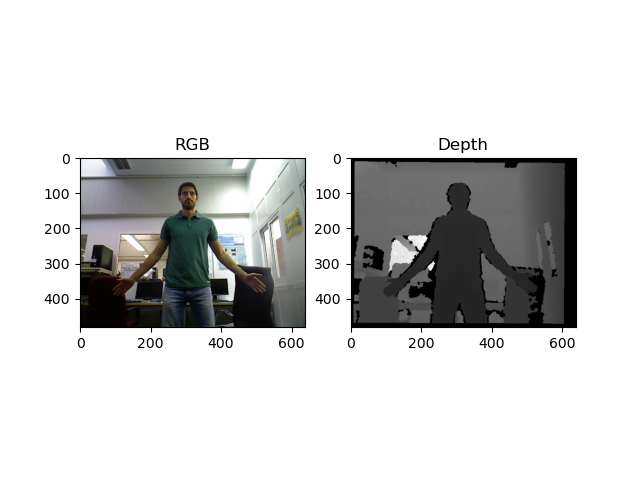

In [11]:
# Read images


# Show RGB


# Show depth


As we have the actual depth of the points, the only thing to do is getting the projection lines of the points.

First, we need to transform the points in image coordinates to sensor coordinates. For this, we reverse the sensor to image method seen previously, either using a right pseudoinverse or **isolating the variables**.

We know that *(guessing that axis scale is 1)*:

$$\bf{2D \rightarrow 2D} \qquad \underbrace{\begin{bmatrix} x' \\ y'\\ 1 \end{bmatrix}}_{\text{pixels}} = \begin{bmatrix} f & 0 & x_0  \\ 0 & f & y_0 \\ 0 & 0 & 1 \end{bmatrix} \underbrace{\begin{bmatrix} x \\ y\\ 1 \end{bmatrix}}_{\text{meters}}$$

If we isolate $x$ and $y$, we get the coordinates in the sensor:

$$\begin{eqnarray} x = \frac{x'-x_0}{f} \\[3pt] y = \frac{y-y_0}{f} \end{eqnarray}$$

Finally, we add the depth component $Z$, which it's avaiable in the depth image:

$$3D \rightarrow 2D \; \ \text{for} \; \ f=1 \quad \begin{bmatrix} X \\ Y\\ Z \end{bmatrix} = Z \begin{bmatrix} x \\ y\\ 1 \end{bmatrix}$$

**What to do?** Get the 3D camera frame coordinates (size $3\times n\_points$) from the image `person_rgb.png`, using the intrinsic parameters:

$
f = 525, \
k_x = 1, \
k_y = 1, \
x_0 = 319.5, \
y_0 = 239.5 \
$

*Note that python indexing starts in the top-left corner, you will have to adapt the transformation before applying the formula above.*

In [12]:
# Read images


# Import intrinsic parameters


# Matrix for storing sensor coordinates


# Get sensor coordinates

        # Adapt coordinates to python indexing
    
        
        # Transform to sensor coordinates
        

# Convert coordinates to homogenous


# Add depth


[[-15.35142857 -15.19714286 -15.04285714]
 [  0.69428571   0.69428571   0.69428571]
 [ 81.          81.          81.        ]]


You can **test if results are correct** (Positions of camera frame for points nº 100060, 100061 and 100062):

<font color='blue'>**Expected output:**  </font>

    [[-15.35142857 -15.19714286 -15.04285714]
     [  0.69428571   0.69428571   0.69428571]
     [ 81.          81.          81.        ]]



Here comes the fun part! We have developed a 3D scatter plot for this exercise, it shows a 3D maps of a RGB-D image using the points we calculed. 

**What to do?** Call the method `plot3DScene` that takes as input the 3D coordinates of the points and the original RGB image (for the colors).

<IPython.core.display.Javascript object>


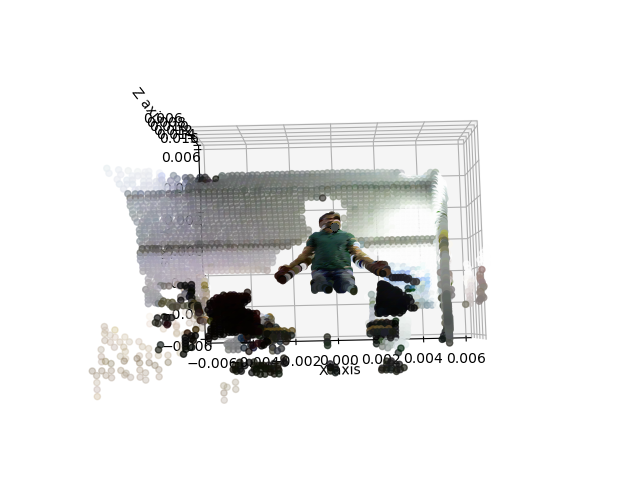

In [13]:
plot3DScene(map_3d,image)

Finally, we are going to move the camera position and transform back the image to 2D. For this, you should use the full transformation from world frame to image:

$$\lambda \begin{bmatrix} x' \\ y'\\ 1 \end{bmatrix} = \begin{bmatrix} f  & 0 & x'_0  \\ 0 & f  & y'_0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} \bf{R} & \bf{t}\end{bmatrix} \begin{bmatrix} X_W \\ Y_W\\ Z_W \\ 1 \end{bmatrix} \qquad \bf{\lambda \tilde{m}' = K \left[ R\ t \right] \tilde{M}_W}$$

Note that if the image with the new perspective wants to be shown, it is necessary to choose the pixels that are closer to the camera position. This can be done using the depth band, e.g. show the pixels whose depth is lower.

**What to do?** Define a rotation + translation matrix, which represents a movement to the camera. Then, apply camera model to the previous computed 3D map, in order to reproduce an image showing what the camera would see from that position.

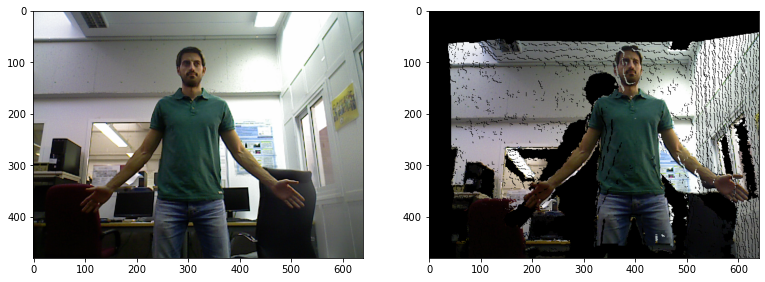

In [14]:
%matplotlib inline

# Define transformation matrices


# Transform map to homogenous


# Apply transformation


# Transform to cartesian


# Construct new image

         # Check if pixel is in bounds
             # Check if pixel is closer than other in that position
            
# Show original image

## Conclusion

Although this is a dense chapter, it is satisfying once you get it. In this notebook, you have learned:

- how Pinhole model works
- how camera model works
- how to transform a 3D world into a 2D image, and the other way around
- how RGB-D images work (widely used in computer vision ans robotics fields)